# INSTALL DEPENDENCIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Qt5Agg')
import cv2

In [3]:
colorImgBgr = cv2.imread(r'../../Downloads/download.png')
grayImg = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)
grayAlb = cv2.imread(r'../../Downloads/albert-einstein_gray.jpg', cv2.IMREAD_GRAYSCALE)

In [4]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

# BILINEAR TRANSFORMATION

In [5]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthBottom * a
        return np.uint8(g)
    else:
        return 0

# ROTATION IMPLEMENTATION

In [6]:
def f_getExtents(T, rMax, cMax):
    coords = np.array([[0,0], [0, cMax - 1], [rMax - 1, 0], [rMax - 1, cMax -1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [7]:
def f_transform(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# AFFINE TRANSFORMATION

In [8]:
def f_getExtentsAffine(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [9]:
def f_transformAffine(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# PROJECTIVE TRANSFORMATION HOMOGRAPHY

In [10]:
def f_getExtentsProjective(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [11]:
def f_transformProjective(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsProjective(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

In [12]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
H = np.array(A)
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [13]:
H[2,:] = np.array([0.0001, 0.0001, 1])
H

array([[ 1.12583302e+00, -8.70834875e-02, -2.91651246e+00],
       [ 3.50000000e-01,  7.81217783e-01, -1.74871131e+01],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e+00]])

In [14]:
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


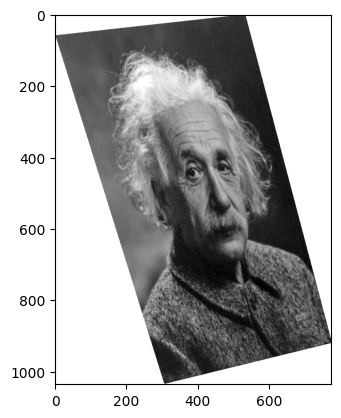

In [15]:
I2 = f_transformProjective(H,grayAlb)
plt.imshow(I2,cmap='gray')

In [16]:
def f_getPoints(I,numPts):
    %matplotlib inline
    fig,ax = plt.subplots(1,figsize=(15,30))
    plt.imshow(I,cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts)))
    pts = pts[:,[1,0]].T
    plt.close()
    return pts

In [32]:
# pts = f_getPoints(grayAlb, 4)
pts = np.array([[397., 387., 477., 631.], [317., 389., 440., 412.]])

In [33]:
P = np.array([[402.,400.,479.],[320.,499.,443.]])

In [34]:
P

array([[402., 400., 479.],
       [320., 499., 443.]])

In [35]:
P_dash = np.array([[487., 471., 569.],
       [389., 530., 515.]])

In [36]:
P_dash

array([[487., 471., 569.],
       [389., 530., 515.]])

In [37]:
P = np.vstack((P,np.ones((1,3))))

In [38]:
P

array([[402., 400., 479.],
       [320., 499., 443.],
       [  1.,   1.,   1.]])

In [39]:
np.linalg.det(P)

-14028.99999999999

In [42]:
A = P_dash.dot(np.linalg.inv(P))

In [44]:
A

array([[  1.18654216,  -0.07612802,  34.37101718],
       [  0.37144486,   0.79185972, -13.71594554]])

array([[-3.99173141e-03, -5.63119253e-03,  4.40665764e+00],
       [-8.76755293e-03,  5.48863069e-03,  1.76819445e+00],
       [ 1.27592843e-02,  1.42561836e-04, -5.17485209e+00]])